# Simple Monte Carlo Inference of Foreground Halo Masses

##### David Thomas, SLAC 2016

In this notebook we infer the halo masses a small number of individual halos in front of a tiny patch of background, weakly-lensed galaxies. First we explore the probabilistic graphical model (PGM) for this simple inference, and then we use Simple Monte Carlo sampling to characterize the halo mass posterior PDFs.

### Requirements

To run this notebook, you will need the `daft` package installed:
```
pip install daft
```

## The PGM
For more an introduction to PGMS see Daphne Koller's [Probabilistic Graphical Models](http://pgm.stanford.edu/). Below is the PGM that we will explore in this notebook.

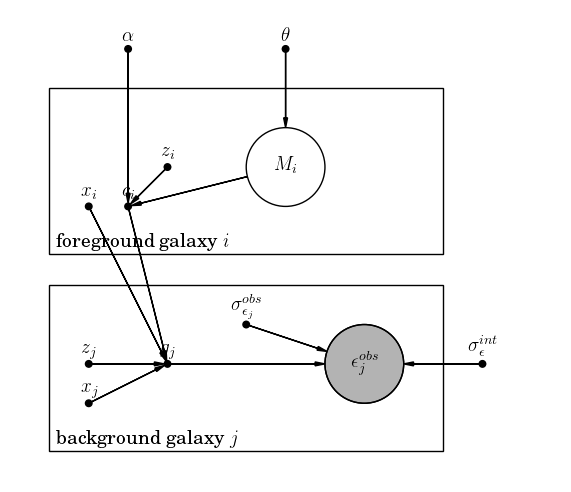

In [3]:
%matplotlib inline

from matplotlib import rc
rc("font", family="serif", size=14)
rc("text", usetex=True)

import daft

pgm = daft.PGM([7, 6], origin=[0, 0])

#background nodes
pgm.add_plate(daft.Plate([0.5, 3.0, 5, 2], label=r"foreground galaxy $i$",
    shift=-0.1))
pgm.add_node(daft.Node("theta", r"$\theta$", 3.5, 5.5, fixed=True))
pgm.add_node(daft.Node("alpha", r"$\alpha$", 1.5, 5.5, fixed=True))
pgm.add_node(daft.Node("halo_mass", r"$M_i$", 3.5, 4, scale=2))
pgm.add_node(daft.Node("background_z", r"$z_i$", 2, 4, fixed=True))
pgm.add_node(daft.Node("concentration", r"$c_i$", 1.5, 3.5, fixed=True))
pgm.add_node(daft.Node("background_x", r"$x_i$", 1.0, 3.5, fixed=True))

#foreground nodes
pgm.add_plate(daft.Plate([0.5, 0.5, 5, 2], label=r"background galaxy $j$",
    shift=-0.1))
pgm.add_node(daft.Node("reduced_shear", r"$g_j$", 2.0, 1.5, fixed=True))
pgm.add_node(daft.Node("reduced_shear", r"$g_j$", 2.0, 1.5, fixed=True))
pgm.add_node(daft.Node("foreground_z", r"$z_j$", 1.0, 1.5, fixed=True))
pgm.add_node(daft.Node("foreground_x", r"$x_j$", 1.0, 1.0, fixed=True))
pgm.add_node(daft.Node("ellipticities", r"$\epsilon_j^{obs}$", 4.5, 1.5, observed=True, scale=2))

#outer nodes
pgm.add_node(daft.Node("sigma_obs", r"$\sigma_{\epsilon_j}^{obs}$", 3.0, 2.0, fixed=True))
pgm.add_node(daft.Node("sigma_int", r"$\sigma_{\epsilon}^{int}$", 6.0, 1.5, fixed=True))

#edges
pgm.add_edge("foreground_z", "reduced_shear")
pgm.add_edge("foreground_x", "reduced_shear")
pgm.add_edge("reduced_shear", "ellipticities")
pgm.add_edge("sigma_obs", "ellipticities")
pgm.add_edge("sigma_int", "ellipticities")
pgm.add_edge("concentration", "reduced_shear")
pgm.add_edge("halo_mass", "concentration")
pgm.add_edge("background_z", "concentration")
pgm.add_edge("background_x", "reduced_shear")
pgm.add_edge("alpha", "concentration")
pgm.add_edge("theta", "halo_mass")
pgm.render()

We have sets of foregrounds and backgrounds along with the variables

- $\alpha$:  parameters in the concentration function (which is a function of $z_i,M_i$)
- $\theta$: prior distribution of halo masses
- $z_i$: foreground galaxy redshift
- $x_i$: foreground galaxy angular coordinates
- $z_j$: background galaxy redshift
- $x_j$: background galaxy angular coordinates
- $g_j$: reduced shear
- $\sigma_{\epsilon_j}^{obs}$: noise from our ellipticity measurement process
- $\sigma_{\epsilon}^{int}$: intrinsic variance in ellipticities
- $\epsilon_j^{obs}$: intrinsic variance in ellipticities

## Stellar Mass Threshold
To speed up our computation we filter the halos in our foreground by their stellar mass. Ideally we would like ~10 halos per square arcminute. The Millennium Simulatin covers 144 square arcuminutes. Hence we would like to select for the brightest 1440 halos in the simulation.

In [5]:
from pandas import read_table
from pangloss import GUO_FILE

m_h = 'M_Subhalo[M_sol/h]'
m_s = 'M_Stellar[M_sol/h]'

guo_data = read_table(GUO_FILE)
nonzero_guo_data= guo_data[guo_data[m_h] > 0]

In [21]:
nonzero_guo_data[[m_h, m_s]].corr()

,M_Subhalo[M_sol/h],M_Stellar[M_sol/h]
M_Subhalo[M_sol/h],1.00000,0.56123
M_Stellar[M_sol/h],0.56123,1.00000


In [22]:
# desired threshold
guo_data.sort(m_s, ascending=False)[1440:1441]

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,GalID,HaloID,SubhaloID,Type,PlaneNumber,z_spec,pos_0[rad],pos_1[rad],Dc_los[Mpc/h],M_Halo[M_sol/h],M_Subhalo[M_sol/h],M_Stellar[M_sol/h],mag_SDSS_u,mag_SDSS_g,mag_SDSS_r,mag_SDSS_i,mag_SDSS_z,mag_J,mag_H,mag_K
186262,410000215000026,410000215000026,37041000002158,0,37,1.33642,-0.023452,-0.02505,2939.85,1.203200e+12,1.257420e+12,5.883920e+10,25.6378,25.5546,24.8604,24.232,23.5833,22.3069,21.856,21.1317


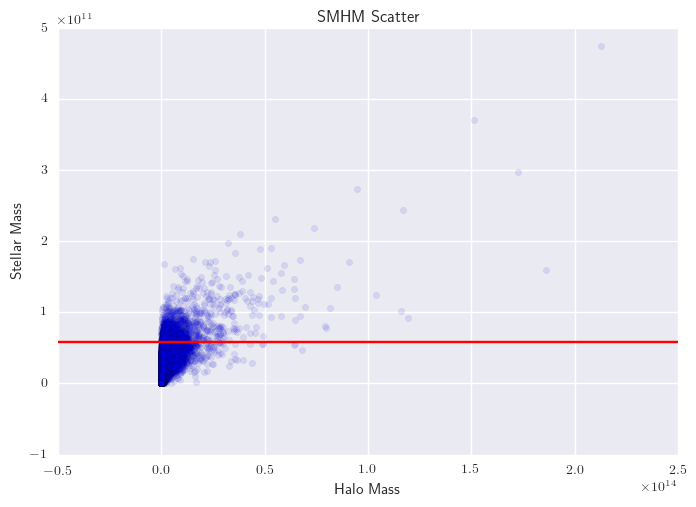

In [163]:
import matplotlib.pyplot as plt

stellar_mass_threshold = 5.883920e+10
plt.scatter(nonzero_guo_data[m_h], nonzero_guo_data[m_s], alpha=0.1)
plt.axhline(y=stellar_mass_threshold, color='red')
plt.xlabel('Halo Mass')
plt.ylabel('Stellar Mass')
plt.title('SMHM Scatter')

In [9]:
stellar_mass_threshold

58839200000.0

In [50]:
m_logspace

array([  3.35665000e+05,   7.07352287e+05,   1.49061492e+06,
         3.14119695e+06,   6.61949516e+06,   1.39493693e+07,
         2.93957316e+07,   6.19461010e+07,   1.30540021e+08,
         2.75089099e+08,   5.79699710e+08,   1.22161058e+09,
         2.57431975e+09,   5.42490566e+09,   1.14319915e+10,
         2.40908207e+10,   5.07669763e+10,   1.06982071e+11,
         2.25445049e+11,   4.75084000e+11])

In [57]:
from math import log

start = log(nonzero_guo_data[m_s].min(), 10)
stop = log(nonzero_guo_data[m_s].max(), 10)

m_logspace = np.logspace(start, stop, num=20, base=10)[:-1]

In [58]:
m_corrs = []
thin_data = nonzero_guo_data[[m_s, m_h]]
for cutoff in m_logspace:
    tmp = thin_data[nonzero_guo_data[m_s] > cutoff]
    m_corrs.append(tmp.corr()[m_s][1])

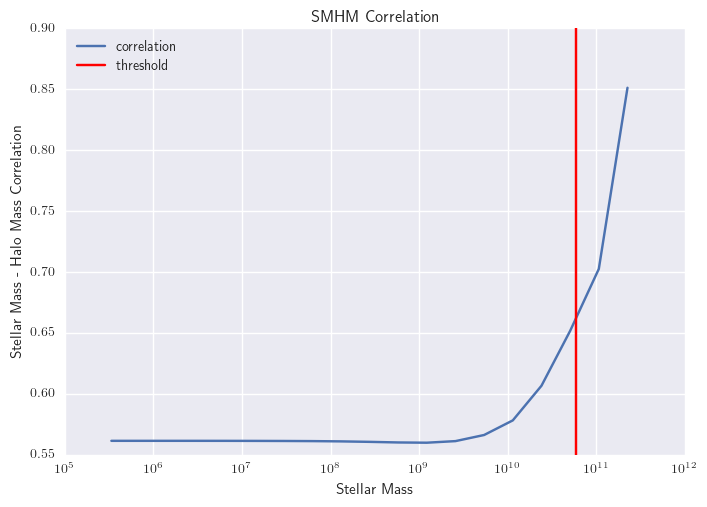

In [162]:
plt.plot(m_logspace, m_corrs, label='correlation')
plt.axvline(x=stellar_mass_threshold, color='red', label='threshold')
plt.xscale('log')
plt.legend(loc=2)
plt.xlabel('Stellar Mass')
plt.ylabel('Stellar Mass - Halo Mass Correlation')
plt.title('SMHM Correlation')

In [147]:
hist = np.histogram(nonzero_guo_data[m_s], bins=m_logspace, normed=False)

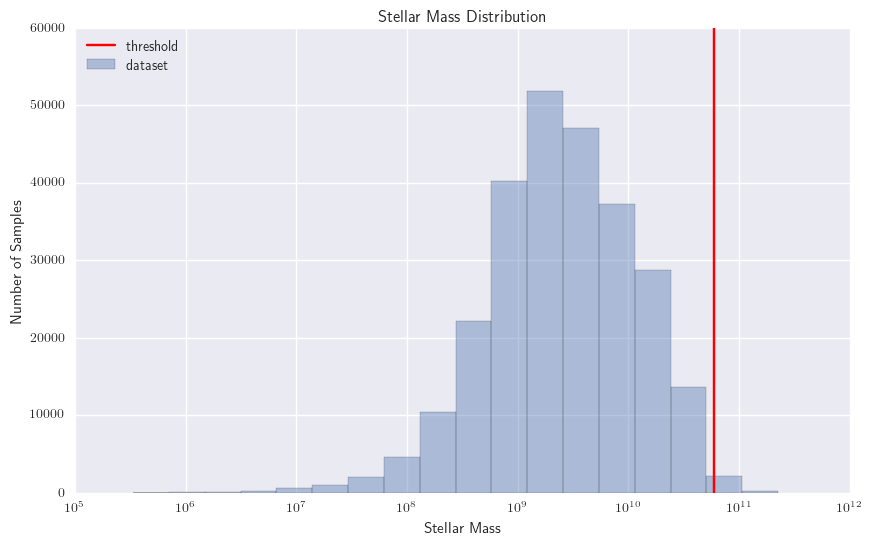

In [195]:
plt.rcParams['figure.figsize'] = (10, 6)
# plt.plot(hist[1][:-1], hist[0], label='correlation')
plt.hist(nonzero_guo_data[m_s], bins=m_logspace, alpha=0.4, normed=False, label='dataset')
plt.axvline(x=stellar_mass_threshold, color='red', label='threshold')
plt.xscale('log')
plt.legend(loc=2)
plt.xlabel('Stellar Mass')
plt.ylabel('Number of Samples')
plt.title('Stellar Mass Distribution')

## Inference

We use the Simple Monte Carlo to generate many samples from the posterior PDF for $M$:
```
1. Draw prior samples
2. Compute log likelihood
3. Renormalize and exponentiate log likelihood values and assign to samples as importance weights
4. Compute integral inferences as weighted sums over the samples
```

In [77]:
%load_ext autoreload
%autoreload 2

from pangloss import BackgroundCatalog, ForegroundCatalog, \
    TrueHaloMassDistribution, Kappamap, Shearmap
from pandas import DataFrame

# initialize background and foreground
B = BackgroundCatalog(N=10.0, domain=[1.43, 1.4, -1.43, -1.4], field=[0, 0, 0, 0])
F = ForegroundCatalog.guo()
F.set_mass_prior(TrueHaloMassDistribution()) # This needs explaining...

# lens the background galaxies with the model halos - i.e., this notebook is a functional test!
B.drill_lightcones(radius=2, foreground=F)
B.lens_by_halos(relevance_lim=0.00001, lookup_table=True, smooth_corr=True)

K = Kappamap.example()
S = Shearmap.example()

# run monte carlo samples
output = DataFrame()
for _ in range(2):
    F.draw_halo_masses()
    B.drill_lightcones(radius=1.0, foreground=F, save=False, smooth_corr=True)
    B.lens_by_halos(relevance_lim=0.00001, lookup_table=True, smooth_corr=True)
    B.lens_by_map(K, S)
    halos = B.get_sampled_halo_masses_in_lightcones()
    halos['log-likelihood'] = B.halo_mass_log_likelihood()
    output = output.append(halos, ignore_index=True)

# galaxies that were filtered due to relevance should be assigned mass of 0
output = output.fillna(0)
output

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


AttributeError: type object 'ForegroundCatalog' has no attribute 'guo'

In [4]:
B.get_true_halo_masses_in_lightcones()

,1.8001242e+13,1.80012420005e+13,1.80012420012e+13,1.80022480001e+13,1.8005715e+13,1.8007889e+13,2.8000156e+13,2.80001560005e+13,2.80001560006e+13,2.80001560007e+13,...,4.97000377e+14,4.97003629e+14,4.97003629001e+14,4.97003629001e+14,4.97003629001e+14,4.97011203e+14,5.00023445e+14,5.00025485e+14,5.01010108004e+14,5.01030332e+14
0,4.839470e+12,1.825450e+12,1.144670e+11,2.272130e+11,1.024180e+11,8.176240e+10,2.526030e+12,3.872960e+10,6.971320e+10,2.754100e+11,...,1.136070e+11,2.616400e+12,1.807380e+10,4.045090e+10,4.045090e+10,6.885260e+10,2.065580e+10,2.409840e+10,1.979510e+10,2.065580e+10


## Initial Results

In [164]:
from pandas import read_csv

res = read_csv('../data.csv')
tru = read_csv('../true.csv')

In [88]:
tru

,Unnamed: 0,3.7000046e+13,3.70145220095e+13,6.5000614e+13,7.4004925e+13,4.19000237e+14,4.36017617e+14,4.56000089e+14,4.56000089003e+14,4.67000103001e+14
0,0,1.876400e+13,1.782420e+12,8.288130e+11,1.165590e+13,1.230740e+12,2.565620e+12,1.568200e+13,5.606320e+12,1.067560e+13


In [166]:
res.max().max()

212683000000000.0

In [167]:
for c in res.columns:
    print res[c][res[c] > 0].min()

1
1.81513e+12
1.48463e+12
2.15422e+12
1.73939e+12
3.54591e+12
157500000000.0
100697000000.0
8.27091e+12
190205000000.0
4.09587e+12
3.17755e+12
8.21153e+12
3.23302074101


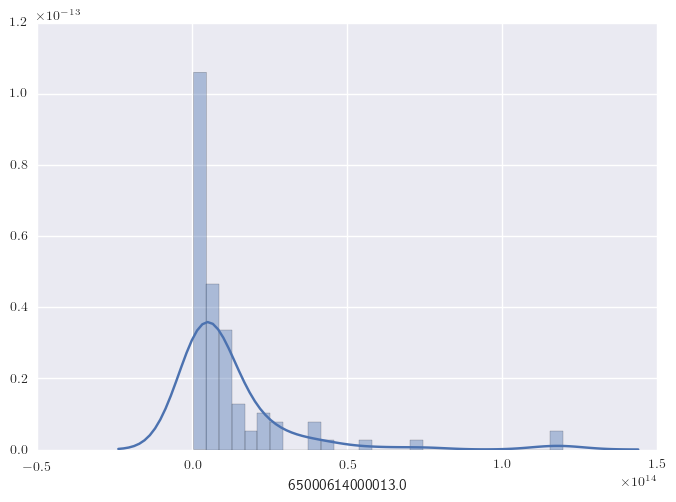

In [103]:
import seaborn as sns

sns.distplot(res['65000614000013.0'][res['65000614000013.0'] > 0])

In [168]:
base = 10
start = log(100697000000.0, base)
end = log(212683000000000.0, base)
res_logspace = np.logspace(start, end, num=20, base=base)

In [169]:
res_logspace

array([  1.00697000e+11,   1.50661261e+11,   2.25416999e+11,
         3.37265353e+11,   5.04611094e+11,   7.54991148e+11,
         1.12960583e+12,   1.69009840e+12,   2.52869853e+12,
         3.78339880e+12,   5.66066153e+12,   8.46939237e+12,
         1.26717711e+13,   1.89593037e+13,   2.83666108e+13,
         4.24416750e+13,   6.35005638e+13,   9.50085405e+13,
         1.42150278e+14,   2.12683000e+14])

In [170]:
res.columns

Index([u'Unnamed: 0', u'112009306000027', u'37000046000024', u'37014522009504',
       u'419000237000015', u'436017617000017', u'456000089000011',
       u'456000089002589', u'467000103000876', u'65000614000013',
       u'74004925000017', u'82020319006828', u'97000066000025',
       u'log-likelihood'],
      dtype='object')

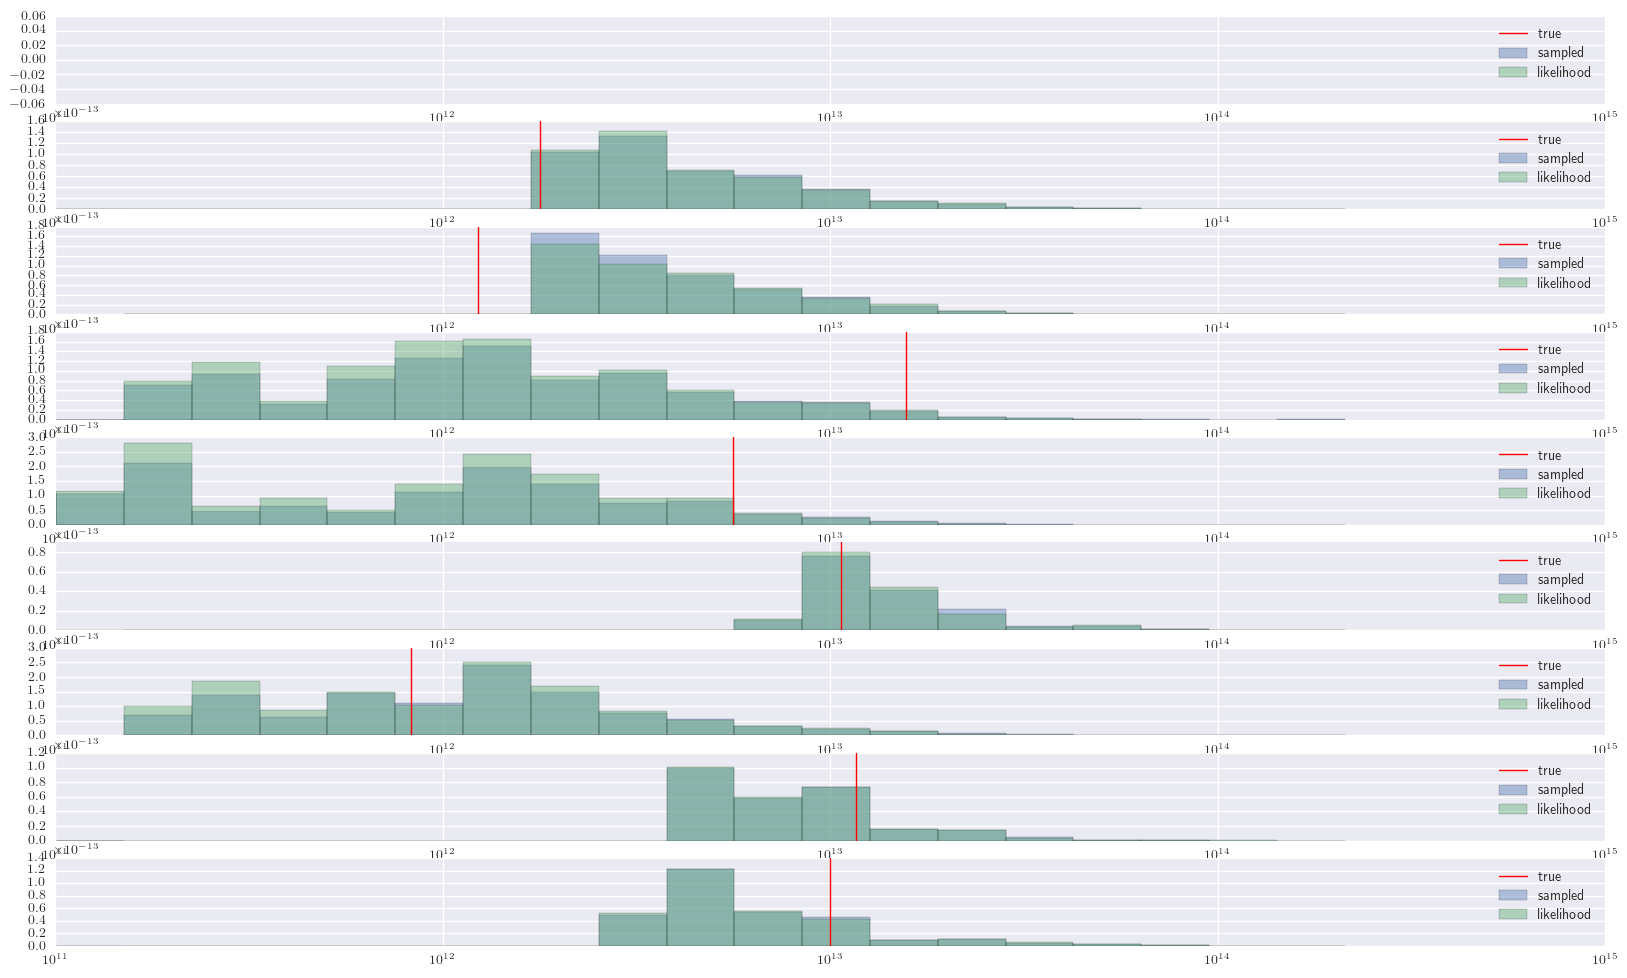

In [192]:
plt.rcParams['figure.figsize'] = (20, 12)

for i,val in enumerate(tru.columns):
    plt.subplot(int('91' + str(i+1)))
    x = res[val][res[val] > 0]
    weights = np.exp(res['log-likelihood'][res[val] > 0])
    t = tru[val].loc[0]
    plt.hist(x, bins=res_logspace, alpha=0.4, normed=True, label='sampled')
    plt.hist(x, bins=res_logspace, weights=weights, alpha=0.4, normed=True, label='likelihood')
    plt.axvline(x=t, color='red', label='true', linewidth=1)
    plt.xscale('log')
    plt.legend()
plt.show()

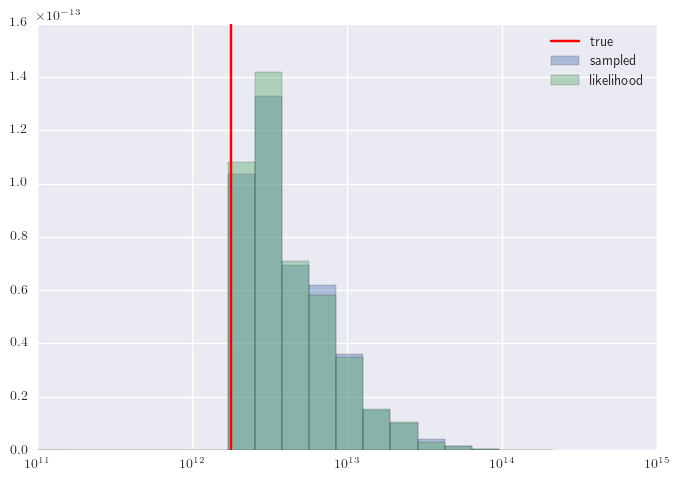

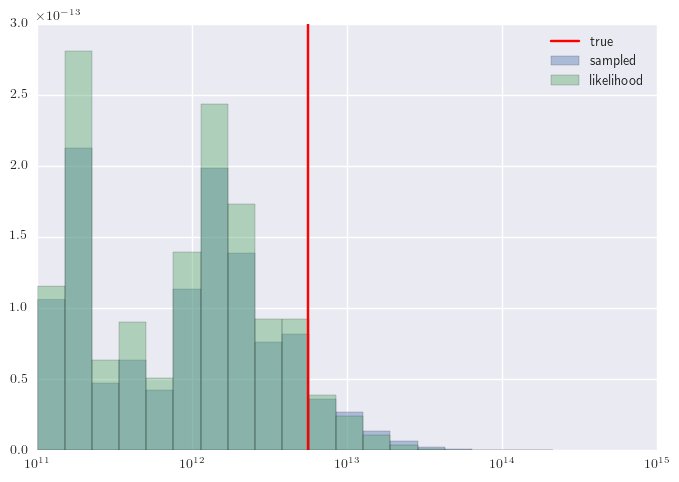

In [179]:
key = '37014522009504'
x = res[key][res[key] > 0]
weights = np.exp(res['log-likelihood'][res[key] > 0])
t = tru[key].loc[0]
plt.hist(x, bins=res_logspace, alpha=0.4, normed=True, label='sampled')
plt.hist(x, bins=res_logspace, weights=weights, alpha=0.4, normed=True, label='likelihood')
plt.axvline(x=t, color='red', label='true')
plt.xscale('log')
plt.legend()
plt.show()

key = '456000089002589'
x = res[key][res[key] > 0]
weights = np.exp(res['log-likelihood'][res[key] > 0])
t = tru[key].loc[0]
plt.hist(x, bins=res_logspace, alpha=0.4, normed=True, label='sampled')
plt.hist(x, bins=res_logspace, weights=weights, alpha=0.4, normed=True, label='likelihood')
plt.axvline(x=t, color='red', label='true')
plt.xscale('log')
plt.legend()
plt.show()



In [172]:
tru

,Unnamed: 0,37014522009504,419000237000015,456000089000011,456000089002589,467000103000876,65000614000013,74004925000017,82020319006828
0,0,1.782420e+12,1.230740e+12,1.568200e+13,5.606320e+12,1.067560e+13,8.288130e+11,1.165590e+13,9.969850e+12


In [197]:
np.exp(res['log-likelihood']).describe()

count    2.000000e+02
mean     3.682493e+02
std      1.375317e+02
min      9.761285e-31
25%      3.069375e+02
50%      3.939403e+02
75%      4.700225e+02
max      5.779353e+02
Name: log-likelihood, dtype: float64

## Performance Benchmark

coming soon ...